In [43]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, roc_auc_score


In [3]:

# Load data
df = pd.read_csv('Data/UCI_Credit_Card.csv')

# Preview
print(df.shape)
print(df.head())
print(df.info())

(30000, 25)
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default.payment.next.month  
0       0.0 

<Axes: xlabel='default.payment.next.month', ylabel='count'>

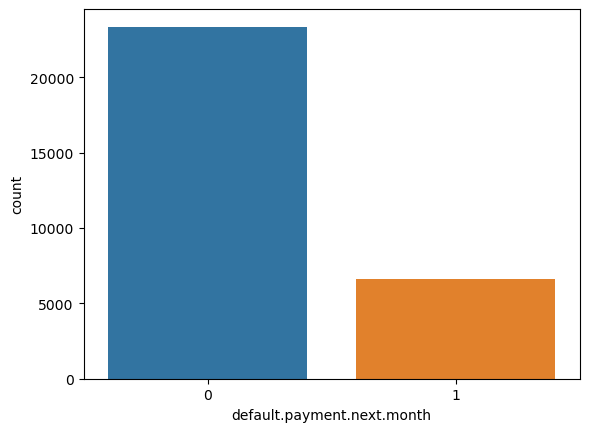

In [5]:

sns.countplot(data=df, x='default.payment.next.month')


In [9]:


print("✅ Target Variable Distribution (Imbalanced Classes):")
print(df['default.payment.next.month'].value_counts(normalize=True).rename({0: "Non-Default", 1: "Default"}), "\n")

print("✅ Gender Distribution (SEX):")
print(df['SEX'].value_counts(normalize=True).rename({1: "Male", 2: "Female"}), "\n")

print("✅ Education Levels (EDUCATION):")
print(df['EDUCATION'].value_counts(), "\n")

print("✅ Marital Status (MARRIAGE):")
print(df['MARRIAGE'].value_counts(), "\n")

print("✅ Age Summary:")
print(df['AGE'].describe(), "\n")

print("✅ Credit Limit (LIMIT_BAL) Summary:")
print(df['LIMIT_BAL'].describe(), "\n")

print("✅ Payment Delay Features (PAY_0 to PAY_6):")
pay_features = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
print(df[pay_features].describe(), "\n")

print("✅ Billing Amounts and Payment Amounts:")
bill_features = ['BILL_AMT1','BILL_AMT2','BILL_AMT3']
pay_amt_features = ['PAY_AMT1','PAY_AMT2','PAY_AMT3']
print(df[bill_features + pay_amt_features].describe())


✅ Target Variable Distribution (Imbalanced Classes):
default.payment.next.month
Non-Default    0.7788
Default        0.2212
Name: proportion, dtype: float64 

✅ Gender Distribution (SEX):
SEX
Female    0.603733
Male      0.396267
Name: proportion, dtype: float64 

✅ Education Levels (EDUCATION):
EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64 

✅ Marital Status (MARRIAGE):
MARRIAGE
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64 

✅ Age Summary:
count    30000.000000
mean        35.485500
std          9.217904
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64 

✅ Credit Limit (LIMIT_BAL) Summary:
count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

In [13]:
 
### 1. Check Dropping Irrelevant Columns
print("Columns before dropping:", df.columns)
if 'ID' in df.columns:
    df = df.drop(columns=['ID'])
    print("Dropped 'ID' column.")
else:
    print("'ID' column already dropped.")

### 2. Handle Out-of-Range Categorical Values
# Check EDUCATION unique values before and after fix
print("EDUCATION values before fix:", df['EDUCATION'].value_counts())
df['EDUCATION'] = df['EDUCATION'].replace({0: 4, 5: 4, 6: 4})
print("EDUCATION values after fix:", df['EDUCATION'].value_counts())

# Check MARRIAGE values before and after fix
print("MARRIAGE values before fix:", df['MARRIAGE'].value_counts())
df['MARRIAGE'] = df['MARRIAGE'].replace({0: 3})
print("MARRIAGE values after fix:", df['MARRIAGE'].value_counts())

### 3. Check for Missing Values
print("Missing values in each column:")
print(df.isnull().sum())

### 4. Feature/Target Separation
X = df.drop(columns=['default.payment.next.month'])
y = df['default.payment.next.month']
print("X shape:", X.shape)
print("y distribution:\n", y.value_counts(normalize=True))

### 5. Train/Val/Test Split with Stratify
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train size:", len(y_train))
print("Validation size:", len(y_val))
print("Test size:", len(y_test))
print("Class distribution in train:", y_train.value_counts(normalize=True))

### 6. Scaling Numeric Features
# Identify numeric columns to scale
num_cols = ['LIMIT_BAL', 'AGE'] + \
           [col for col in X.columns if 'BILL_AMT' in col or 'PAY_AMT' in col]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val_scaled[num_cols] = scaler.transform(X_val[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# Check scaling effect
print("\nMean of scaled training features (should be ~0):\n", X_train_scaled[num_cols].mean())
print("\nStd of scaled training features (should be ~1):\n", X_train_scaled[num_cols].std())


Columns before dropping: Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')
'ID' column already dropped.
EDUCATION values before fix: EDUCATION
2    14030
1    10585
3     4917
4      468
Name: count, dtype: int64
EDUCATION values after fix: EDUCATION
2    14030
1    10585
3     4917
4      468
Name: count, dtype: int64
MARRIAGE values before fix: MARRIAGE
2    15964
1    13659
3      377
Name: count, dtype: int64
MARRIAGE values after fix: MARRIAGE
2    15964
1    13659
3      377
Name: count, dtype: int64
Missing values in each column:
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY

# Decision Tree

In [42]:

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_val)
print("Decision Tree:")
print(confusion_matrix(y_val, dt_preds))
print(classification_report(y_val, dt_preds))


Decision Tree:
[[3835  838]
 [ 794  533]]
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      4673
           1       0.39      0.40      0.40      1327

    accuracy                           0.73      6000
   macro avg       0.61      0.61      0.61      6000
weighted avg       0.73      0.73      0.73      6000



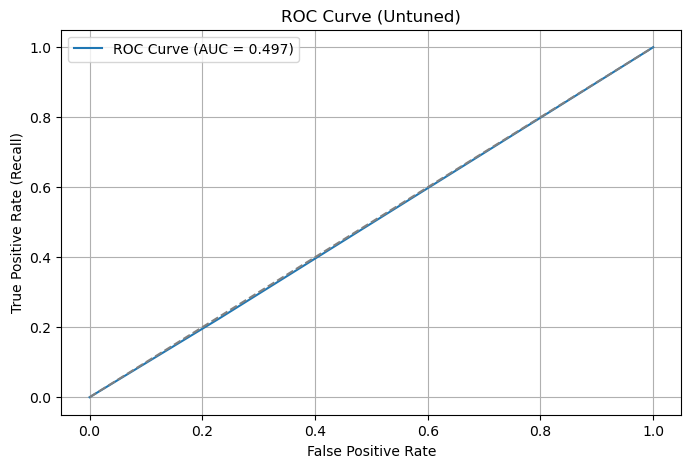

In [45]:
 
# Compute ROC
fpr, tpr, thresholds = roc_curve(y_test, dt_preds)
auc_score = roc_auc_score(y_test, dt_preds)

# Plot ROC
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Untuned)")
plt.legend()
plt.grid(True)
plt.show()

## Hyperpara tuning

In [22]:

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, 
                       cv=5, scoring='f1', n_jobs=-1)
grid_dt.fit(X_train, y_train)

print("Best parameters:", grid_dt.best_params_)
print("Best F1 score from CV:", grid_dt.best_score_)

# Evaluate on validation set
best_dt = grid_dt.best_estimator_
dt_val_preds = best_dt.predict(X_val)
print("Fine-tuned Decision Tree:")
print(classification_report(y_val, dt_val_preds))


/Users/yb/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/yb/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/yb/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/yb/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/yb/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.

Best parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best F1 score from CV: 0.49095452570480774
Fine-tuned Decision Tree:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.65      0.34      0.45      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000



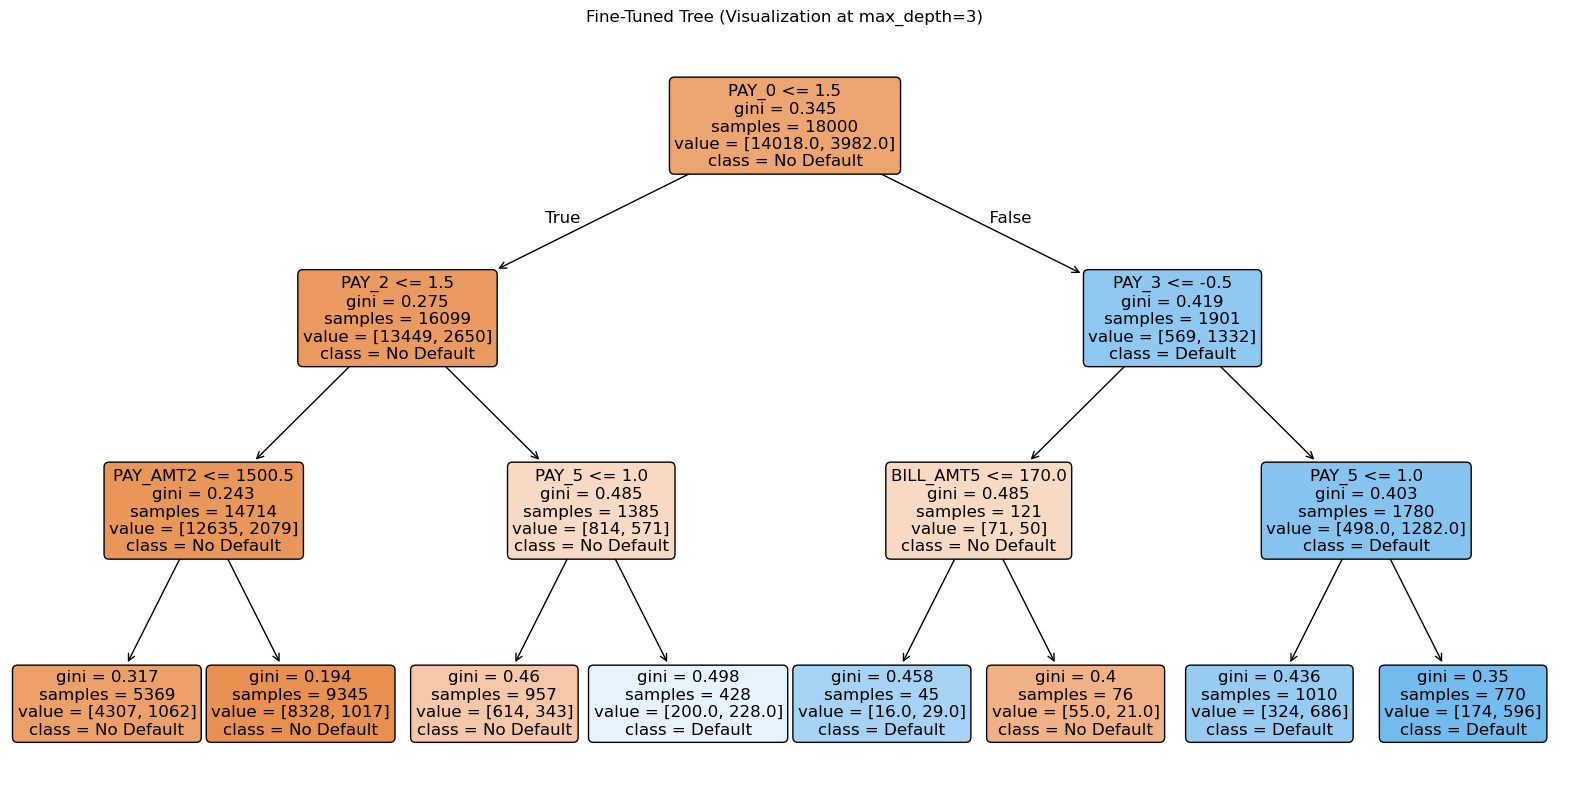

In [23]:
# Use best params, but cap depth for plot
dt_viz = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=best_dt.min_samples_split,
    min_samples_leaf=best_dt.min_samples_leaf,
    random_state=42
)
dt_viz.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(dt_viz, feature_names=X_train.columns, class_names=["No Default", "Default"],
          filled=True, rounded=True, fontsize=12)
plt.title("Fine-Tuned Tree (Visualization at max_depth=3)")
plt.show()



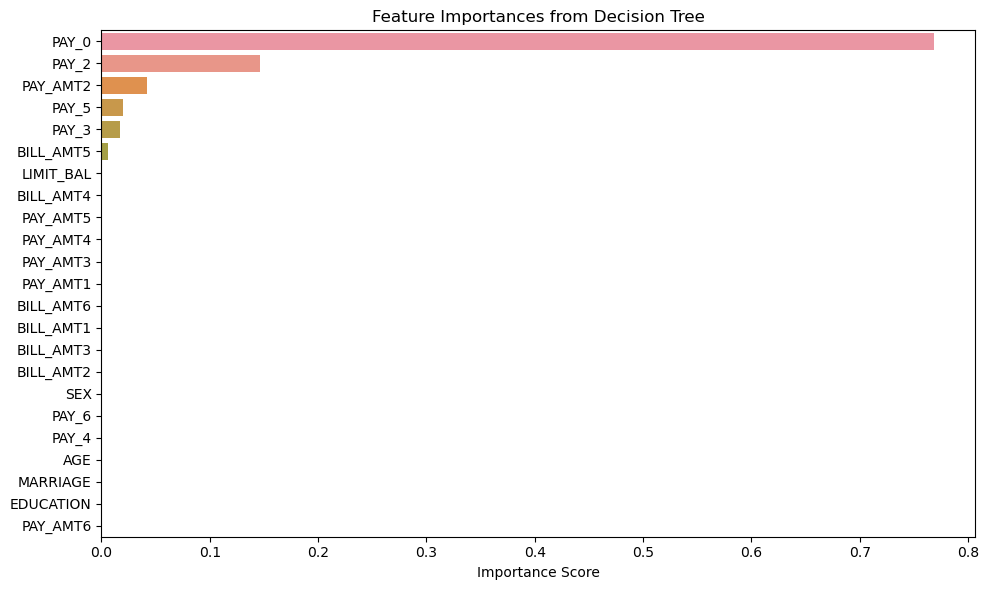

In [24]:
 
importances = best_dt.feature_importances_
feat_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importance.values, y=feat_importance.index)
plt.title("Feature Importances from Decision Tree")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


## Cost sensitivity tuning


In default prediction, false negatives (failing to detect a default) are usually more costly than false positives (mistakenly flagging someone who wouldn't default). So we want the model to penalize mistakes on defaults more heavily.

In [37]:
 
param_grid = {
    'class_weight': [{0:1, 1:w} for w in [1, 2, 5, 10, 20]],
        'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}
scorer = 'recall'  # or 'f1' or 'roc_auc'

dt = DecisionTreeClassifier(max_depth=5, random_state=42)

grid = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)


/Users/yb/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/yb/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/yb/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/yb/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/yb/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 5}, {0: 1, 1: 10},
                                          {0: 1, 1: 20}],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             scoring='recall')

In [38]:
print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)


Best parameters: {'class_weight': {0: 1, 1: 20}, 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best score: 0.9979924717691343


In [39]:
dt_balanced = DecisionTreeClassifier(
    #class_weight="balanced",
    class_weight={0: 1, 1: 20},
  
    max_depth=3,
    min_samples_split=best_dt.min_samples_split,
    min_samples_leaf=best_dt.min_samples_leaf,
    random_state=42
)

dt_balanced.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 20}, max_depth=3, random_state=42)

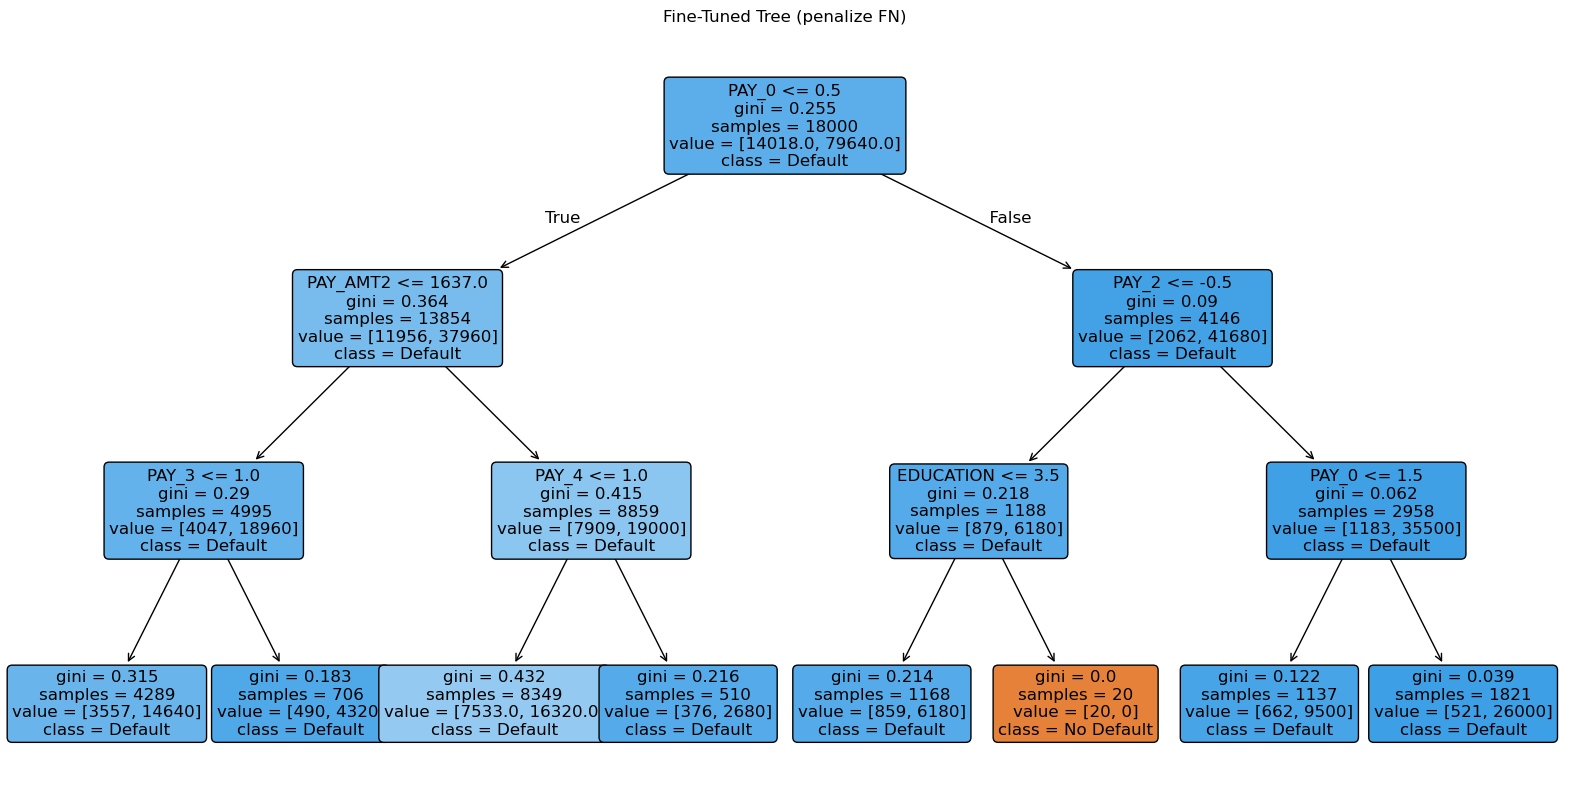

In [40]:

plt.figure(figsize=(20, 10))
plot_tree(dt_balanced , feature_names=X_train.columns, class_names=["No Default", "Default"],
          filled=True, rounded=True, fontsize=12)
plt.title("Fine-Tuned Tree (penalize FN)")
plt.show()


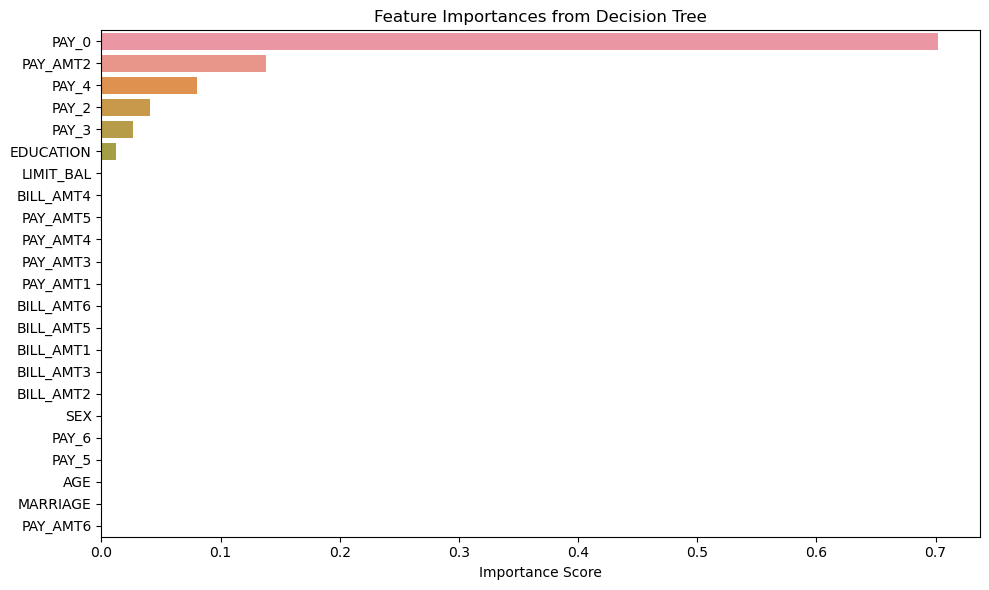

In [41]:
 
importances = dt_balanced.feature_importances_
feat_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importance.values, y=feat_importance.index)
plt.title("Feature Importances from Decision Tree")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


# Random Forest

In [16]:

# 2. Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_val)
print("Random Forest:")
print(confusion_matrix(y_val, rf_preds))
print(classification_report(y_val, rf_preds))




Random Forest:
[[4410  263]
 [ 884  443]]
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      4673
           1       0.63      0.33      0.44      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.64      0.66      6000
weighted avg       0.79      0.81      0.79      6000



hyperpara tuning

In [33]:
 
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
    'class_weight': [None, 'balanced', {0: 1, 1: 5}, {0: 1, 1: 10}]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='recall',  # or 'roc_auc', 'f1'
    cv=5,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
print("Best params:", grid_rf.best_params_)


/Users/yb/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/yb/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/yb/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/yb/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/yb/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.

Best params: {'class_weight': {0: 1, 1: 10}, 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}


In [34]:
rf_preds_grid = grid_rf.predict(X_val)
print("Random Forest:")
print(confusion_matrix(y_val, rf_preds_grid))
print(classification_report(y_val, rf_preds_grid)) 


Random Forest:
[[ 583 4090]
 [  28 1299]]
              precision    recall  f1-score   support

           0       0.95      0.12      0.22      4673
           1       0.24      0.98      0.39      1327

    accuracy                           0.31      6000
   macro avg       0.60      0.55      0.30      6000
weighted avg       0.80      0.31      0.26      6000



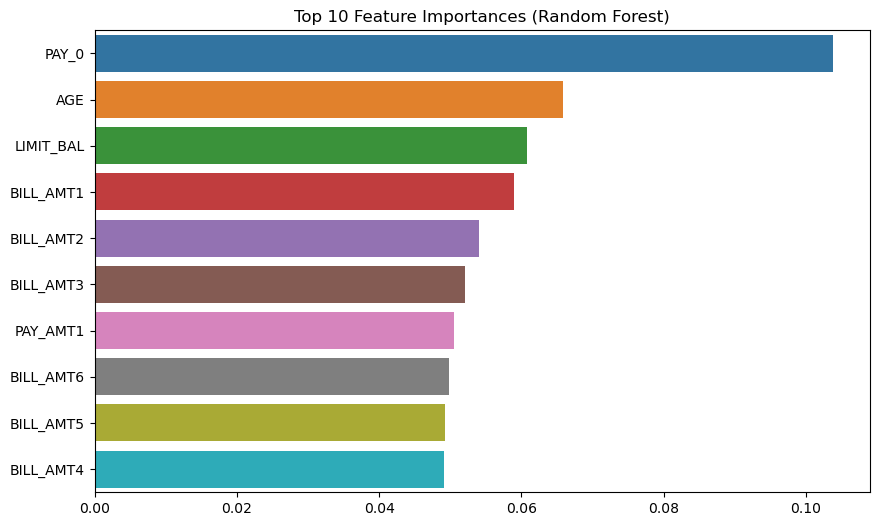

In [35]:
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

In [ ]:
rf = RandomForestClassifier(class_weight={0: 1, 1: 20}, random_state=42)


In [17]:
# 3. XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_val)
print("XGBoost:")
print(confusion_matrix(y_val, xgb_preds))
print(classification_report(y_val, xgb_preds))

/Users/yb/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [03:18:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost:
[[4397  276]
 [ 873  454]]
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      4673
           1       0.62      0.34      0.44      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.64      0.66      6000
weighted avg       0.79      0.81      0.79      6000

